<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Cifar10-128/resized/15*15/cifar10_15_15_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [3]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/cifar10-128.zip -d cifar10-128

Streaming output truncated to the last 5000 lines.
  inflating: cifar10-128/cifar10-128/test/ship.1.jpg  
  inflating: cifar10-128/cifar10-128/test/airplane.10.jpg  
  inflating: cifar10-128/cifar10-128/test/horse.13.jpg  
  inflating: cifar10-128/cifar10-128/test/truck.38.jpg  
  inflating: cifar10-128/cifar10-128/test/frog.43.jpg  
  inflating: cifar10-128/cifar10-128/test/horse.83.jpg  
  inflating: cifar10-128/cifar10-128/test/cat.91.jpg  
  inflating: cifar10-128/cifar10-128/test/frog.102.jpg  
  inflating: cifar10-128/cifar10-128/test/frog.112.jpg  
  inflating: cifar10-128/cifar10-128/test/bird.138.jpg  
  inflating: cifar10-128/cifar10-128/test/frog.142.jpg  
  inflating: cifar10-128/cifar10-128/test/horse.145.jpg  
  inflating: cifar10-128/cifar10-128/test/frog.146.jpg  
  inflating: cifar10-128/cifar10-128/test/frog.163.jpg  
  inflating: cifar10-128/cifar10-128/test/dog.178.jpg  
  inflating: cifar10-128/cifar10-128/test/airplane.180.jpg  
  inflating: cifar10-128/cifar10-12

In [21]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42, 42, 57, 48, 86, 7, 15, 28, 39, 52][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
TRAIN_DIR = "cifar10-128/cifar10-128/train/"
TEST_DIR = "cifar10-128/cifar10-128/test/"
# TEST_DIR = "cifar100_128_fine/cifar100_128_fine/train/"
# TRAIN_DIR = "cifar100_128_fine/cifar100_128_fine/test/"

In [22]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir(TEST_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [23]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

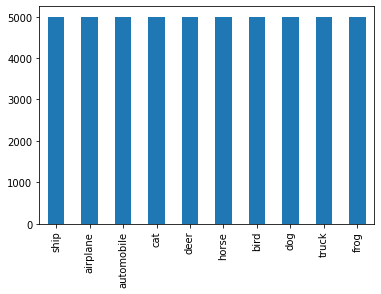

In [24]:
train_df['category'].value_counts().plot.bar()

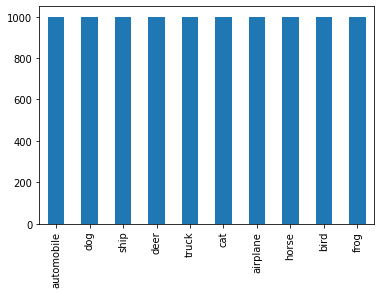

In [25]:
validate_df['category'].value_counts().plot.bar()

In [26]:
train_datagen = ImageDataGenerator(
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 50000 validated image filenames belonging to 10 classes.


In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TEST_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 10000 validated image filenames belonging to 10 classes.


In [28]:
print(train_df.shape)
print(validate_df.shape)

(50000, 2)
(10000, 2)


In [29]:
train_generator.image_shape

(128, 128, 3)

In [30]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

10


In [31]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.25),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = RMSprop(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 114, 114, 32)      21632     
_________________________________________________________________
batch_normalization_4 (Batch (None, 114, 114, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 57, 57, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 57, 57, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)       

In [ ]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = RMSprop(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
1562/1562 [==============================] - 57s 33ms/step - loss: 2.3449 - accuracy: 0.2773 - val_loss: 1.7050 - val_accuracy: 0.4006
Epoch 2/1000
1562/1562 [==============================] - 51s 33ms/step - loss: 1.5330 - accuracy: 0.4468 - val_loss: 1.5365 - val_accuracy: 0.4562
Epoch 3/1000
1562/1562 [==============================] - 50s 32ms/step - loss: 1.4141 - accuracy: 0.4951 - val_loss: 1.2447 - val_accuracy: 0.5628
Epoch 4/1000
1562/1562 [==============================] - 50s 32ms/step - loss: 1.3243 - accuracy: 0.5267 - val_loss: 1.1707 - val_accuracy: 0.5802
Epoch 5/1000
1562/1562 [==============================] - 50s 32ms/step - loss: 1.2571 - accuracy: 0.5576 - val_loss: 1.2423 - val_accuracy: 0.5621
Epoch 6/1000
1562/1562 [==============================] - 50s 32ms/step - loss: 1.2173 - accuracy: 0.5722 - val_loss: 1.1456 - val_accuracy: 0.5940
Epoch 7/1000
1562/1562 [==============================] - 50s 32ms/step - loss: 1.1779 - accuracy: 0.5873 - val_

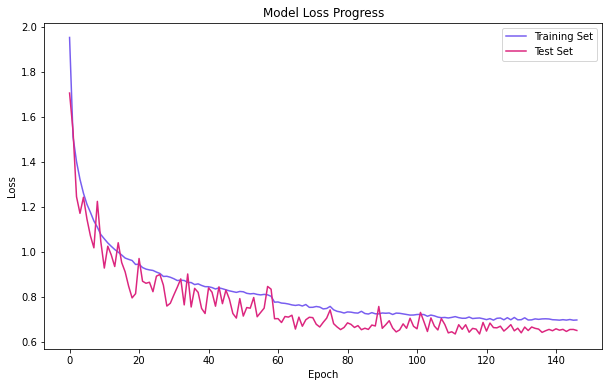

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-loss-gabor-same-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

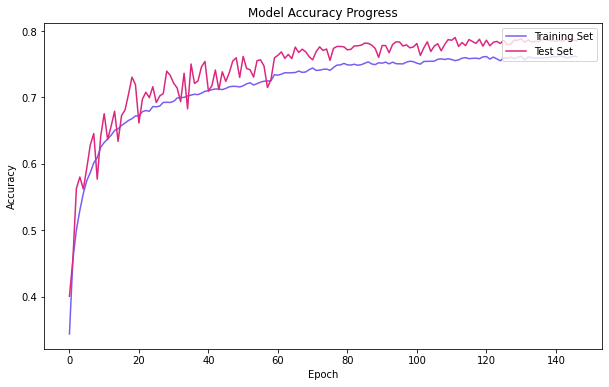

In [20]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-accuracy-gabor-same-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()